In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torchvision

BATCH_SIZE = 256

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
# Statt MNIST laden wir nun den FashionMNIST Datensatz
train_data = torchvision.datasets.FashionMNIST(
    root=".",
    train=True,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST(
        root=".",
        train=False,
        transform=transform,
    ),
    batch_size=BATCH_SIZE,
)


3


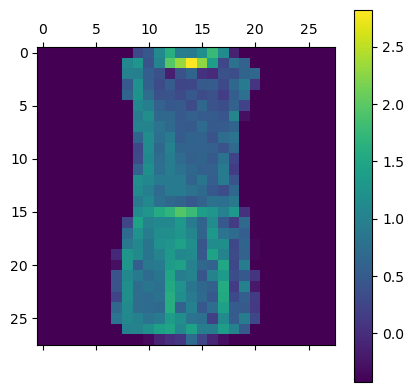

In [3]:
img, label = train_data[1291]

plt.matshow(img[0])
plt.colorbar()
print(label)

In [4]:
from norse.torch import ConstantCurrentLIFEncoder

/opt/conda/lib/python3.11/site-packages/torch/utils/_cxx_pytree.py:235: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
/opt/conda/lib/python3.11/site-packages/torch/utils/_cxx_pytree.py:235: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFBoxParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
2025-02-23 08:19:28.054662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740298768.075287     148 cuda_dnn.cc:8310] Unable to register cuDNN factory: Att

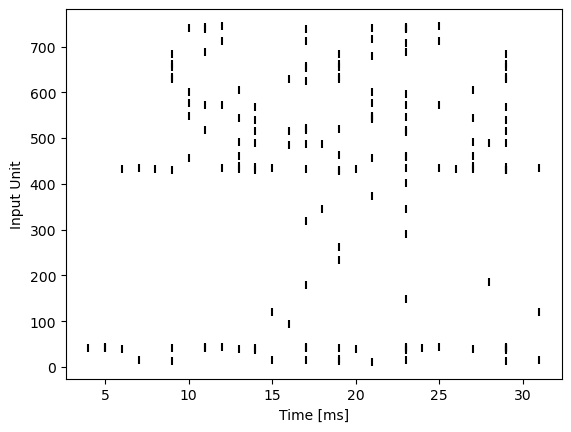

In [5]:
T = 32
example_encoder = ConstantCurrentLIFEncoder(T)


example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

In [6]:
from norse.torch import PoissonEncoder

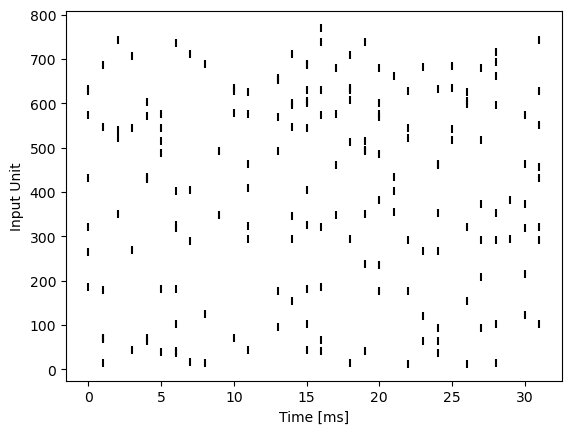

In [7]:
T = 32
example_encoder = PoissonEncoder(T, f_max=20)

example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

In [8]:
from norse.torch import SpikeLatencyLIFEncoder

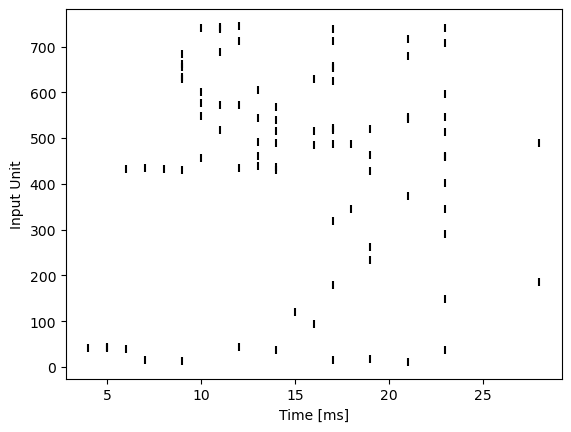

In [9]:
T = 32
example_encoder = SpikeLatencyLIFEncoder(T)


example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

In [10]:
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell

# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState

from typing import NamedTuple


class SNNState(NamedTuple):
    lif0: LIFState
    readout: LIState


class SNN(torch.nn.Module):
    def __init__(
        self, input_features, hidden_features, output_features, record=False, dt=0.001
    ):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(alpha=100, v_th=torch.tensor(0.5)),
            dt=dt,
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record

    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
                LIFState(
                    z=torch.zeros(seq_length, batch_size, self.hidden_features),
                    v=torch.zeros(seq_length, batch_size, self.hidden_features),
                    i=torch.zeros(seq_length, batch_size, self.hidden_features),
                ),
                LIState(
                    v=torch.zeros(seq_length, batch_size, self.output_features),
                    i=torch.zeros(seq_length, batch_size, self.output_features),
                ),
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
                self.recording.lif0.z[ts, :] = s1.z
                self.recording.lif0.v[ts, :] = s1.v
                self.recording.lif0.i[ts, :] = s1.i
                self.recording.readout.v[ts, :] = so.v
                self.recording.readout.i[ts, :] = so.i
            voltages += [vo]

        return torch.stack(voltages)

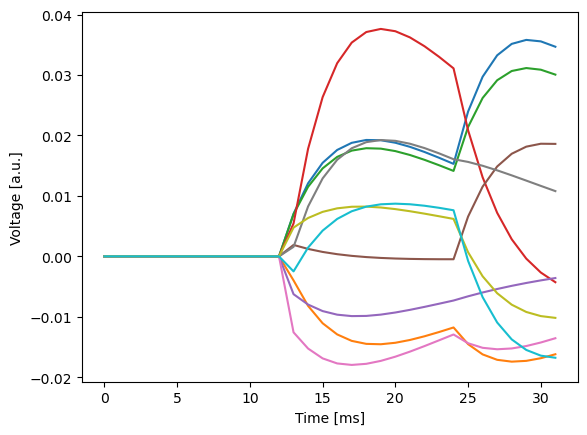

In [11]:
example_snn = SNN(28 * 28, 100, 10, record=True, dt=0.001)

example_readout_voltages = example_snn(example_input.unsqueeze(1))
voltages = example_readout_voltages.squeeze(1).detach().numpy()

plt.plot(voltages)
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()

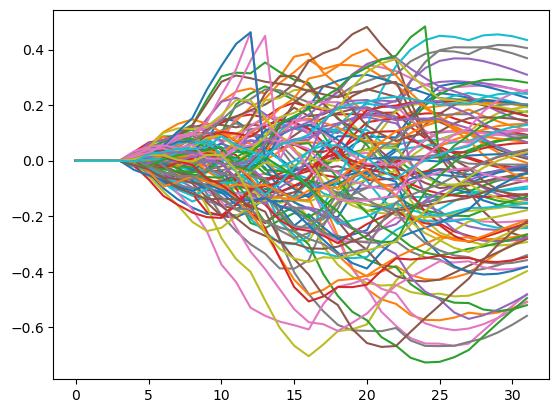

In [12]:
plt.plot(example_snn.recording.lif0.v.squeeze(1).detach().numpy())
plt.show()

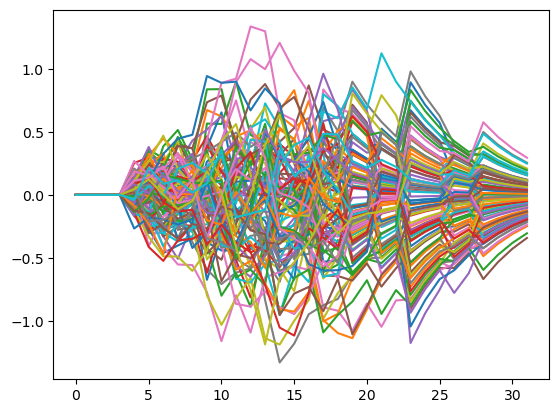

In [13]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

In [26]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

In [27]:
def decode_last(x):
    x = x[-1]
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

In [28]:
class Model(torch.nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [29]:
T = 32
LR = 0.002
INPUT_FEATURES = 28 * 28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=ConstantCurrentLIFEncoder(
        seq_length=T,
    ),
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
    ),
    decoder=decode_last,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): ConstantCurrentLIFEncoder()
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=784, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [30]:
from tqdm.notebook import tqdm, trange

EPOCHS = 60  

def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train()  # Setze das Modell in den Trainingsmodus
    losses = []  # Liste für Verluste
    correct_train = 0  # Anzahl der richtigen Vorhersagen im Training
    total_train = 0  # Gesamtanzahl der Trainingsbeispiele
    
    # Schleife über den Trainingsloader
    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Setze den Gradienten des Optimierers zurück
        output = model(data)  # Modellvorhersage
        loss = torch.nn.functional.nll_loss(output, target)  # Negative log-Likelihood Loss
        loss.backward()  # Berechne Gradienten
        optimizer.step()  # Aktualisiere die Modellparameter
        losses.append(loss.item())  # Füge Verlust zur Liste hinzu
        
        # Berechne die Trainingsgenauigkeit
        pred = output.argmax(dim=1, keepdim=True)  # Bestimme die Vorhersage (Index der höchsten Log-Wahrscheinlichkeit)
        correct_train += pred.eq(target.view_as(pred)).sum().item()  # Zähle richtige Vorhersagen
        total_train += target.size(0)  # Zähle die Gesamtanzahl der Beispiele

    mean_loss = np.mean(losses)  # Berechne den Mittelwert des Verlusts über das Batch
    train_accuracy = 100.0 * correct_train / total_train  # Trainingsgenauigkeit in Prozent
    
    return losses, mean_loss, train_accuracy  # Gebe die Verluste, den Mittelwert und die Trainingsgenauigkeit zurück

In [31]:
def test(model, device, test_loader, epoch):
    model.eval()  # Setze das Modell in den Evaluationsmodus
    test_loss = 0  # Gesamtverlust
    correct = 0  # Anzahl der richtigen Vorhersagen
    
    # Deaktiviere den Gradientenberechnungsmodus
    with torch.no_grad():
        # Schleife über den Testloader
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # Modellvorhersage
            test_loss += torch.nn.functional.nll_loss(output, target, reduction="sum").item()  # Verlust addieren
            
            pred = output.argmax(dim=1, keepdim=True)  # Bestimme die Vorhersage (Index der höchsten Log-Wahrscheinlichkeit)
            correct += pred.eq(target.view_as(pred)).sum().item()  # Zähle richtige Vorhersagen
    
    test_loss /= len(test_loader.dataset)  # Durchschnittlicher Testverlust
    accuracy = 100.0 * correct / len(test_loader.dataset)  # Genauigkeit in Prozent

    return test_loss, accuracy  # Gebe Testverlust und Genauigkeit zurück


In [32]:
from torch.utils.data import random_split

# Aufteilen des Trainingsdatensatzes in Trainings- und Validierungsdatensatz
val_size = int(0.2 * len(train_data))  # 20% für Validierung
train_size = len(train_data) - val_size
train_data, val_data = random_split(train_data, [train_size, val_size])

# DataLoader für den Validierungsdatensatz
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)


In [21]:
# Training und Testen über mehrere Epochen
train_losses = []  # Liste für durchschnittliche Trainingsverluste pro Epoche
test_losses = []   # Liste für durchschnittliche Testverluste pro Epoche
test_accuracies = []  # Liste für Testgenauigkeiten pro Epoche
train_accuracies = []  # Liste für Trainingsgenauigkeiten pro Epoche

for epoch in trange(EPOCHS, desc="Training"):
    # Training
    train_loss, mean_train_loss, train_accuracy = train(model, DEVICE, train_loader, optimizer, epoch, EPOCHS)
    train_losses.append(mean_train_loss)  # Füge den mittleren Trainingsverlust pro Epoche hinzu
    train_accuracies.append(train_accuracy)  # Füge die Trainingsgenauigkeit pro Epoche hinzu
    
    # Testen
    test_loss, test_accuracy = test(model, DEVICE, test_loader, epoch)
    test_losses.append(test_loss)  # Füge den Testverlust pro Epoche hinzu
    test_accuracies.append(test_accuracy)  # Füge die Testgenauigkeit pro Epoche hinzu
    
    # Ausgabe für jedes Epoch
    print(
        f"Epoch {epoch+1}/{EPOCHS}, "
        f"Train Loss: {mean_train_loss:.2f}, "
        f"Train Accuracy: {train_accuracy:.2f}%, "
        f"Test Loss: {test_loss:.2f}, "
        f"Test Accuracy: {test_accuracy:.2f}%"
    )


Training:   0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/60, Train Loss: 0.74, Train Accuracy: 74.22%, Test Loss: 0.61, Test Accuracy: 78.39%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/60, Train Loss: 0.54, Train Accuracy: 80.67%, Test Loss: 0.54, Test Accuracy: 80.50%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/60, Train Loss: 0.49, Train Accuracy: 82.28%, Test Loss: 0.53, Test Accuracy: 81.31%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/60, Train Loss: 0.46, Train Accuracy: 83.24%, Test Loss: 0.50, Test Accuracy: 81.82%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/60, Train Loss: 0.45, Train Accuracy: 83.91%, Test Loss: 0.52, Test Accuracy: 81.35%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/60, Train Loss: 0.43, Train Accuracy: 84.60%, Test Loss: 0.52, Test Accuracy: 81.42%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/60, Train Loss: 0.42, Train Accuracy: 84.85%, Test Loss: 0.50, Test Accuracy: 82.26%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/60, Train Loss: 0.40, Train Accuracy: 85.39%, Test Loss: 0.49, Test Accuracy: 82.49%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/60, Train Loss: 0.38, Train Accuracy: 85.89%, Test Loss: 0.49, Test Accuracy: 82.77%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/60, Train Loss: 0.38, Train Accuracy: 86.18%, Test Loss: 0.50, Test Accuracy: 82.32%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11/60, Train Loss: 0.37, Train Accuracy: 86.36%, Test Loss: 0.52, Test Accuracy: 81.91%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12/60, Train Loss: 0.36, Train Accuracy: 86.75%, Test Loss: 0.50, Test Accuracy: 82.65%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13/60, Train Loss: 0.36, Train Accuracy: 86.84%, Test Loss: 0.49, Test Accuracy: 82.73%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14/60, Train Loss: 0.35, Train Accuracy: 87.35%, Test Loss: 0.48, Test Accuracy: 83.19%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15/60, Train Loss: 0.34, Train Accuracy: 87.36%, Test Loss: 0.49, Test Accuracy: 83.15%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16/60, Train Loss: 0.33, Train Accuracy: 87.78%, Test Loss: 0.48, Test Accuracy: 83.35%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17/60, Train Loss: 0.33, Train Accuracy: 87.90%, Test Loss: 0.50, Test Accuracy: 82.84%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18/60, Train Loss: 0.33, Train Accuracy: 88.03%, Test Loss: 0.51, Test Accuracy: 82.92%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19/60, Train Loss: 0.32, Train Accuracy: 88.28%, Test Loss: 0.50, Test Accuracy: 83.17%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20/60, Train Loss: 0.32, Train Accuracy: 88.17%, Test Loss: 0.51, Test Accuracy: 83.06%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21/60, Train Loss: 0.31, Train Accuracy: 88.59%, Test Loss: 0.50, Test Accuracy: 83.83%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22/60, Train Loss: 0.31, Train Accuracy: 88.64%, Test Loss: 0.52, Test Accuracy: 82.98%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23/60, Train Loss: 0.30, Train Accuracy: 88.91%, Test Loss: 0.50, Test Accuracy: 83.66%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24/60, Train Loss: 0.30, Train Accuracy: 89.07%, Test Loss: 0.51, Test Accuracy: 83.28%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25/60, Train Loss: 0.29, Train Accuracy: 89.06%, Test Loss: 0.51, Test Accuracy: 83.55%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26/60, Train Loss: 0.29, Train Accuracy: 89.41%, Test Loss: 0.52, Test Accuracy: 83.31%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27/60, Train Loss: 0.29, Train Accuracy: 89.29%, Test Loss: 0.54, Test Accuracy: 82.67%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28/60, Train Loss: 0.28, Train Accuracy: 89.66%, Test Loss: 0.53, Test Accuracy: 82.83%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29/60, Train Loss: 0.28, Train Accuracy: 89.67%, Test Loss: 0.52, Test Accuracy: 83.75%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30/60, Train Loss: 0.28, Train Accuracy: 89.71%, Test Loss: 0.52, Test Accuracy: 83.53%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31/60, Train Loss: 0.27, Train Accuracy: 90.07%, Test Loss: 0.54, Test Accuracy: 83.30%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32/60, Train Loss: 0.27, Train Accuracy: 90.04%, Test Loss: 0.55, Test Accuracy: 83.48%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33/60, Train Loss: 0.27, Train Accuracy: 90.21%, Test Loss: 0.53, Test Accuracy: 83.65%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34/60, Train Loss: 0.27, Train Accuracy: 90.24%, Test Loss: 0.54, Test Accuracy: 83.15%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35/60, Train Loss: 0.26, Train Accuracy: 90.23%, Test Loss: 0.58, Test Accuracy: 82.74%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36/60, Train Loss: 0.26, Train Accuracy: 90.45%, Test Loss: 0.54, Test Accuracy: 83.52%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37/60, Train Loss: 0.26, Train Accuracy: 90.48%, Test Loss: 0.55, Test Accuracy: 83.19%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38/60, Train Loss: 0.25, Train Accuracy: 90.72%, Test Loss: 0.56, Test Accuracy: 83.15%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39/60, Train Loss: 0.26, Train Accuracy: 90.49%, Test Loss: 0.58, Test Accuracy: 82.75%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40/60, Train Loss: 0.25, Train Accuracy: 90.86%, Test Loss: 0.57, Test Accuracy: 83.36%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41/60, Train Loss: 0.24, Train Accuracy: 91.06%, Test Loss: 0.57, Test Accuracy: 82.86%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42/60, Train Loss: 0.25, Train Accuracy: 90.78%, Test Loss: 0.58, Test Accuracy: 82.91%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43/60, Train Loss: 0.24, Train Accuracy: 91.16%, Test Loss: 0.58, Test Accuracy: 82.89%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44/60, Train Loss: 0.24, Train Accuracy: 91.22%, Test Loss: 0.61, Test Accuracy: 82.42%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45/60, Train Loss: 0.24, Train Accuracy: 91.25%, Test Loss: 0.59, Test Accuracy: 82.86%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46/60, Train Loss: 0.24, Train Accuracy: 91.33%, Test Loss: 0.58, Test Accuracy: 83.24%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47/60, Train Loss: 0.23, Train Accuracy: 91.46%, Test Loss: 0.62, Test Accuracy: 82.02%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48/60, Train Loss: 0.23, Train Accuracy: 91.50%, Test Loss: 0.60, Test Accuracy: 82.93%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49/60, Train Loss: 0.22, Train Accuracy: 91.71%, Test Loss: 0.60, Test Accuracy: 83.06%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 50/60, Train Loss: 0.22, Train Accuracy: 91.70%, Test Loss: 0.61, Test Accuracy: 83.09%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 51/60, Train Loss: 0.23, Train Accuracy: 91.57%, Test Loss: 0.62, Test Accuracy: 82.28%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 52/60, Train Loss: 0.23, Train Accuracy: 91.54%, Test Loss: 0.61, Test Accuracy: 82.85%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 53/60, Train Loss: 0.22, Train Accuracy: 91.89%, Test Loss: 0.61, Test Accuracy: 83.15%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 54/60, Train Loss: 0.22, Train Accuracy: 91.67%, Test Loss: 0.61, Test Accuracy: 82.84%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 55/60, Train Loss: 0.22, Train Accuracy: 92.08%, Test Loss: 0.63, Test Accuracy: 82.47%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 56/60, Train Loss: 0.22, Train Accuracy: 91.91%, Test Loss: 0.63, Test Accuracy: 82.46%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 57/60, Train Loss: 0.22, Train Accuracy: 91.95%, Test Loss: 0.65, Test Accuracy: 82.38%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 58/60, Train Loss: 0.22, Train Accuracy: 91.98%, Test Loss: 0.66, Test Accuracy: 82.19%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 59/60, Train Loss: 0.21, Train Accuracy: 92.02%, Test Loss: 0.66, Test Accuracy: 82.47%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 60/60, Train Loss: 0.21, Train Accuracy: 92.28%, Test Loss: 0.65, Test Accuracy: 82.98%


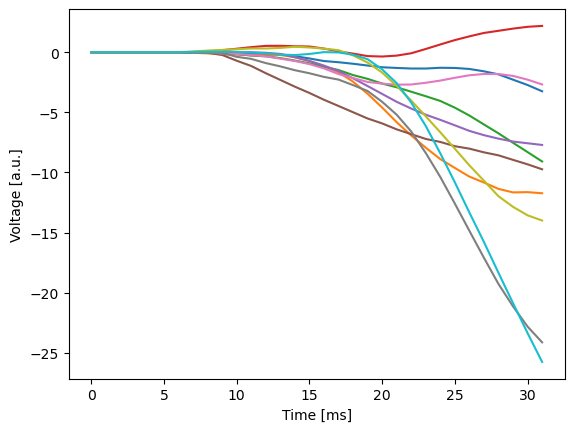

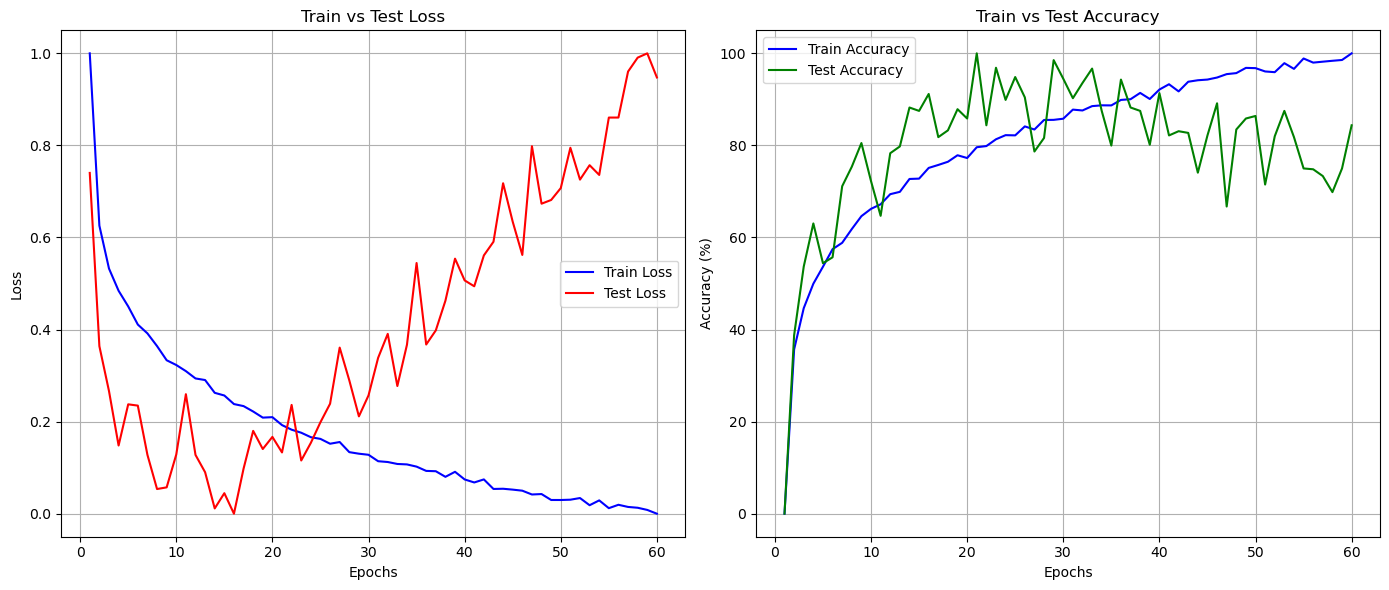

In [22]:
trained_snn = model.snn.cpu()
trained_readout_voltages = trained_snn(example_input.unsqueeze(1))
plt.plot(trained_readout_voltages.squeeze(1).detach().numpy())

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()


# Funktion zum Normalisieren der Loss-Werte auf den Bereich [0, 1]
def normalize_loss(losses):
    max_loss = np.max(losses)
    min_loss = np.min(losses)
    return (losses - min_loss) / (max_loss - min_loss)

# Beispiel für die Normalisierung der Loss-Werte
normalized_train_losses = normalize_loss(train_losses)
normalized_test_losses = normalize_loss(test_losses)

# Normalisierung der Accuracy-Werte auf den Bereich [0, 100]
def normalize_accuracy(accuracies):
    max_accuracy = np.max(accuracies)
    min_accuracy = np.min(accuracies)
    return (accuracies - min_accuracy) * 100 / (max_accuracy - min_accuracy)

# Falls du die Accuracies normalisieren möchtest
normalized_train_accuracies = normalize_accuracy(np.array(train_accuracies))
normalized_test_accuracies = normalize_accuracy(np.array(test_accuracies))

epochs = np.arange(1, EPOCHS + 1)

# Plotten der Verlust- und Genauigkeitsdiagramme
plt.figure(figsize=(14, 6))

# Subplot für den Verlust
plt.subplot(1, 2, 1)
plt.plot(epochs, normalized_train_losses[:EPOCHS], label="Train Loss", color="blue")
plt.plot(epochs, normalized_test_losses[:EPOCHS], label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)

# Subplot für die Genauigkeit
plt.subplot(1, 2, 2)
plt.plot(epochs, normalized_train_accuracies[:EPOCHS], label="Train Accuracy", color="blue")
plt.plot(epochs, normalized_test_accuracies[:EPOCHS], label="Test Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


5 Epochen
final accuracy: 81.37 mit decode

15 Epochs final accuracy: 83.66 mit decode

5 Epochs final accuracy: 81.78 mit decode_last

15 Epochs final accuracy: 83.72 mit decode_last

## Modifying --> SpikeLatencyLIFEncoder

In [23]:
import importlib
from norse.torch.module import encode

encode = importlib.reload(encode)

In [24]:
# from norse.torch.module import encode

T = 32
LR = 0.002
INPUT_FEATURES = 28 * 28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=encode.SpikeLatencyLIFEncoder(T),
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
    ),
    decoder=decode,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): SpikeLatencyLIFEncoder()
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=784, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [25]:
# Training und Testen über mehrere Epochen
train_losses = []  # Liste für durchschnittliche Trainingsverluste pro Epoche
test_losses = []   # Liste für durchschnittliche Testverluste pro Epoche
test_accuracies = []  # Liste für Testgenauigkeiten pro Epoche
train_accuracies = []  # Liste für Trainingsgenauigkeiten pro Epoche

for epoch in trange(EPOCHS, desc="Training"):
    # Training
    train_loss, mean_train_loss, train_accuracy = train(model, DEVICE, train_loader, optimizer, epoch, EPOCHS)
    train_losses.append(mean_train_loss)  # Füge den mittleren Trainingsverlust pro Epoche hinzu
    train_accuracies.append(train_accuracy)  # Füge die Trainingsgenauigkeit pro Epoche hinzu
    
    # Testen
    test_loss, test_accuracy = test(model, DEVICE, test_loader, epoch)
    test_losses.append(test_loss)  # Füge den Testverlust pro Epoche hinzu
    test_accuracies.append(test_accuracy)  # Füge die Testgenauigkeit pro Epoche hinzu
    
    # Ausgabe für jedes Epoch
    print(
        f"Epoch {epoch+1}/{EPOCHS}, "
        f"Train Loss: {mean_train_loss:.2f}, "
        f"Train Accuracy: {train_accuracy:.2f}%, "
        f"Test Loss: {test_loss:.2f}, "
        f"Test Accuracy: {test_accuracy:.2f}%"
    )


Training:   0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/60, Train Loss: 0.83, Train Accuracy: 70.95%, Test Loss: 0.65, Test Accuracy: 76.85%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/60, Train Loss: 0.57, Train Accuracy: 79.57%, Test Loss: 0.59, Test Accuracy: 79.03%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/60, Train Loss: 0.53, Train Accuracy: 81.01%, Test Loss: 0.56, Test Accuracy: 80.24%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/60, Train Loss: 0.51, Train Accuracy: 81.90%, Test Loss: 0.54, Test Accuracy: 80.82%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/60, Train Loss: 0.49, Train Accuracy: 82.31%, Test Loss: 0.54, Test Accuracy: 80.62%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/60, Train Loss: 0.47, Train Accuracy: 83.09%, Test Loss: 0.52, Test Accuracy: 81.20%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/60, Train Loss: 0.46, Train Accuracy: 83.46%, Test Loss: 0.51, Test Accuracy: 81.48%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/60, Train Loss: 0.44, Train Accuracy: 84.08%, Test Loss: 0.51, Test Accuracy: 81.99%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/60, Train Loss: 0.43, Train Accuracy: 84.34%, Test Loss: 0.50, Test Accuracy: 82.23%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/60, Train Loss: 0.42, Train Accuracy: 84.69%, Test Loss: 0.51, Test Accuracy: 82.17%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11/60, Train Loss: 0.42, Train Accuracy: 84.91%, Test Loss: 0.51, Test Accuracy: 81.75%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12/60, Train Loss: 0.41, Train Accuracy: 85.11%, Test Loss: 0.49, Test Accuracy: 82.65%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13/60, Train Loss: 0.40, Train Accuracy: 85.64%, Test Loss: 0.50, Test Accuracy: 82.76%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14/60, Train Loss: 0.40, Train Accuracy: 85.70%, Test Loss: 0.49, Test Accuracy: 82.49%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15/60, Train Loss: 0.39, Train Accuracy: 85.88%, Test Loss: 0.50, Test Accuracy: 82.25%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16/60, Train Loss: 0.38, Train Accuracy: 86.17%, Test Loss: 0.52, Test Accuracy: 82.60%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17/60, Train Loss: 0.38, Train Accuracy: 86.29%, Test Loss: 0.49, Test Accuracy: 82.92%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18/60, Train Loss: 0.37, Train Accuracy: 86.56%, Test Loss: 0.49, Test Accuracy: 82.68%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19/60, Train Loss: 0.37, Train Accuracy: 86.80%, Test Loss: 0.49, Test Accuracy: 82.94%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20/60, Train Loss: 0.36, Train Accuracy: 87.01%, Test Loss: 0.48, Test Accuracy: 83.16%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21/60, Train Loss: 0.35, Train Accuracy: 87.20%, Test Loss: 0.48, Test Accuracy: 83.28%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22/60, Train Loss: 0.36, Train Accuracy: 87.11%, Test Loss: 0.49, Test Accuracy: 83.13%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23/60, Train Loss: 0.35, Train Accuracy: 87.41%, Test Loss: 0.50, Test Accuracy: 82.61%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24/60, Train Loss: 0.35, Train Accuracy: 87.31%, Test Loss: 0.50, Test Accuracy: 82.61%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25/60, Train Loss: 0.34, Train Accuracy: 87.64%, Test Loss: 0.49, Test Accuracy: 83.12%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26/60, Train Loss: 0.33, Train Accuracy: 87.97%, Test Loss: 0.48, Test Accuracy: 83.17%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27/60, Train Loss: 0.33, Train Accuracy: 87.85%, Test Loss: 0.49, Test Accuracy: 83.82%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28/60, Train Loss: 0.33, Train Accuracy: 88.06%, Test Loss: 0.49, Test Accuracy: 83.41%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29/60, Train Loss: 0.32, Train Accuracy: 88.20%, Test Loss: 0.49, Test Accuracy: 83.49%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30/60, Train Loss: 0.32, Train Accuracy: 88.35%, Test Loss: 0.52, Test Accuracy: 83.21%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31/60, Train Loss: 0.32, Train Accuracy: 88.45%, Test Loss: 0.50, Test Accuracy: 83.28%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32/60, Train Loss: 0.32, Train Accuracy: 88.42%, Test Loss: 0.50, Test Accuracy: 83.54%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33/60, Train Loss: 0.31, Train Accuracy: 88.63%, Test Loss: 0.50, Test Accuracy: 83.94%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34/60, Train Loss: 0.31, Train Accuracy: 88.80%, Test Loss: 0.50, Test Accuracy: 83.85%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35/60, Train Loss: 0.30, Train Accuracy: 89.11%, Test Loss: 0.51, Test Accuracy: 83.47%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36/60, Train Loss: 0.30, Train Accuracy: 88.82%, Test Loss: 0.51, Test Accuracy: 83.61%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37/60, Train Loss: 0.30, Train Accuracy: 89.17%, Test Loss: 0.52, Test Accuracy: 83.35%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38/60, Train Loss: 0.29, Train Accuracy: 89.19%, Test Loss: 0.51, Test Accuracy: 83.55%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39/60, Train Loss: 0.29, Train Accuracy: 89.33%, Test Loss: 0.55, Test Accuracy: 82.56%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40/60, Train Loss: 0.29, Train Accuracy: 89.33%, Test Loss: 0.51, Test Accuracy: 83.74%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41/60, Train Loss: 0.28, Train Accuracy: 89.54%, Test Loss: 0.51, Test Accuracy: 83.65%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42/60, Train Loss: 0.28, Train Accuracy: 89.61%, Test Loss: 0.51, Test Accuracy: 83.49%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43/60, Train Loss: 0.28, Train Accuracy: 89.70%, Test Loss: 0.54, Test Accuracy: 82.97%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44/60, Train Loss: 0.28, Train Accuracy: 89.62%, Test Loss: 0.53, Test Accuracy: 83.81%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45/60, Train Loss: 0.27, Train Accuracy: 90.06%, Test Loss: 0.53, Test Accuracy: 83.27%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46/60, Train Loss: 0.27, Train Accuracy: 90.04%, Test Loss: 0.53, Test Accuracy: 83.66%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47/60, Train Loss: 0.27, Train Accuracy: 90.34%, Test Loss: 0.54, Test Accuracy: 83.04%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48/60, Train Loss: 0.26, Train Accuracy: 90.35%, Test Loss: 0.53, Test Accuracy: 83.39%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49/60, Train Loss: 0.26, Train Accuracy: 90.52%, Test Loss: 0.54, Test Accuracy: 83.80%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 50/60, Train Loss: 0.25, Train Accuracy: 90.62%, Test Loss: 0.53, Test Accuracy: 83.80%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 51/60, Train Loss: 0.25, Train Accuracy: 90.74%, Test Loss: 0.54, Test Accuracy: 83.30%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 52/60, Train Loss: 0.25, Train Accuracy: 90.58%, Test Loss: 0.54, Test Accuracy: 83.61%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 53/60, Train Loss: 0.25, Train Accuracy: 90.84%, Test Loss: 0.54, Test Accuracy: 83.70%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 54/60, Train Loss: 0.25, Train Accuracy: 90.94%, Test Loss: 0.57, Test Accuracy: 83.30%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 55/60, Train Loss: 0.24, Train Accuracy: 91.11%, Test Loss: 0.55, Test Accuracy: 83.56%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 56/60, Train Loss: 0.24, Train Accuracy: 91.07%, Test Loss: 0.56, Test Accuracy: 83.22%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 57/60, Train Loss: 0.24, Train Accuracy: 91.22%, Test Loss: 0.56, Test Accuracy: 83.26%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 58/60, Train Loss: 0.24, Train Accuracy: 91.22%, Test Loss: 0.56, Test Accuracy: 83.29%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 59/60, Train Loss: 0.24, Train Accuracy: 91.34%, Test Loss: 0.58, Test Accuracy: 83.13%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 60/60, Train Loss: 0.23, Train Accuracy: 91.62%, Test Loss: 0.57, Test Accuracy: 83.51%


15 Epochs final accuracy: 82.73 mit decode

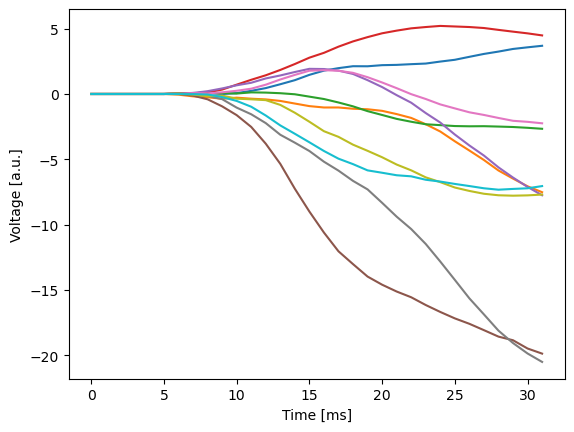

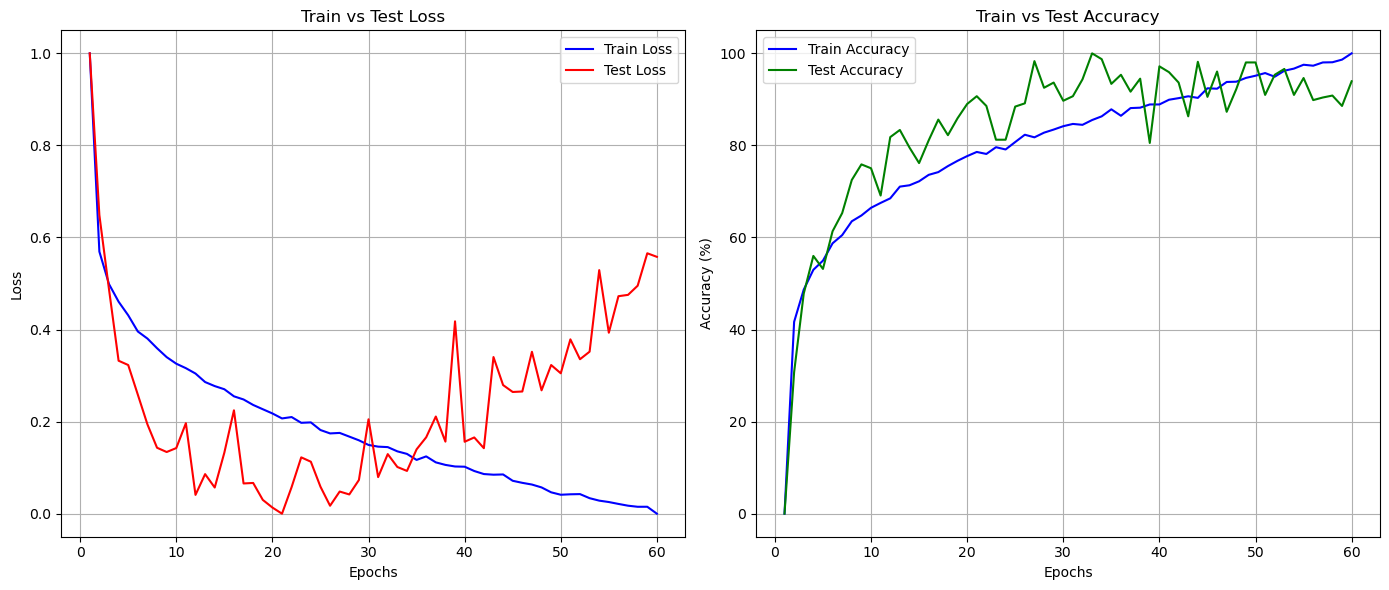

In [26]:
trained_snn = model.snn.cpu()
trained_readout_voltages = trained_snn(example_input.unsqueeze(1))
plt.plot(trained_readout_voltages.squeeze(1).detach().numpy())

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()


# Funktion zum Normalisieren der Loss-Werte auf den Bereich [0, 1]
def normalize_loss(losses):
    max_loss = np.max(losses)
    min_loss = np.min(losses)
    return (losses - min_loss) / (max_loss - min_loss)

# Beispiel für die Normalisierung der Loss-Werte
normalized_train_losses = normalize_loss(train_losses)
normalized_test_losses = normalize_loss(test_losses)

# Normalisierung der Accuracy-Werte auf den Bereich [0, 100]
def normalize_accuracy(accuracies):
    max_accuracy = np.max(accuracies)
    min_accuracy = np.min(accuracies)
    return (accuracies - min_accuracy) * 100 / (max_accuracy - min_accuracy)

# Falls du die Accuracies normalisieren möchtest
normalized_train_accuracies = normalize_accuracy(np.array(train_accuracies))
normalized_test_accuracies = normalize_accuracy(np.array(test_accuracies))

epochs = np.arange(1, EPOCHS + 1)

# Plotten der Verlust- und Genauigkeitsdiagramme
plt.figure(figsize=(14, 6))

# Subplot für den Verlust
plt.subplot(1, 2, 1)
plt.plot(epochs, normalized_train_losses[:EPOCHS], label="Train Loss", color="blue")
plt.plot(epochs, normalized_test_losses[:EPOCHS], label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)

# Subplot für die Genauigkeit
plt.subplot(1, 2, 2)
plt.plot(epochs, normalized_train_accuracies[:EPOCHS], label="Train Accuracy", color="blue")
plt.plot(epochs, normalized_test_accuracies[:EPOCHS], label="Test Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Poison input

In [27]:
T = 32
LR = 0.005
INPUT_FEATURES = 28 * 28
HIDDEN_FEATURES = 200
OUTPUT_FEATURES = 10

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=encode.PoissonEncoder(T, f_max=20),
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
    ),
    decoder=decode,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): PoissonEncoder()
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=784, hidden_size=200, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=200, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [28]:
# Training und Testen über mehrere Epochen
train_losses = []  # Liste für durchschnittliche Trainingsverluste pro Epoche
test_losses = []   # Liste für durchschnittliche Testverluste pro Epoche
test_accuracies = []  # Liste für Testgenauigkeiten pro Epoche
train_accuracies = []  # Liste für Trainingsgenauigkeiten pro Epoche

for epoch in trange(EPOCHS, desc="Training"):
    # Training
    train_loss, mean_train_loss, train_accuracy = train(model, DEVICE, train_loader, optimizer, epoch, EPOCHS)
    train_losses.append(mean_train_loss)  # Füge den mittleren Trainingsverlust pro Epoche hinzu
    train_accuracies.append(train_accuracy)  # Füge die Trainingsgenauigkeit pro Epoche hinzu
    
    # Testen
    test_loss, test_accuracy = test(model, DEVICE, test_loader, epoch)
    test_losses.append(test_loss)  # Füge den Testverlust pro Epoche hinzu
    test_accuracies.append(test_accuracy)  # Füge die Testgenauigkeit pro Epoche hinzu
    
    # Ausgabe für jedes Epoch
    print(
        f"Epoch {epoch+1}/{EPOCHS}, "
        f"Train Loss: {mean_train_loss:.2f}, "
        f"Train Accuracy: {train_accuracy:.2f}%, "
        f"Test Loss: {test_loss:.2f}, "
        f"Test Accuracy: {test_accuracy:.2f}%"
    )


Training:   0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/60, Train Loss: 0.80, Train Accuracy: 70.96%, Test Loss: 0.68, Test Accuracy: 74.73%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/60, Train Loss: 0.63, Train Accuracy: 76.94%, Test Loss: 0.62, Test Accuracy: 77.34%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/60, Train Loss: 0.60, Train Accuracy: 78.06%, Test Loss: 0.60, Test Accuracy: 78.17%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/60, Train Loss: 0.56, Train Accuracy: 79.05%, Test Loss: 0.58, Test Accuracy: 78.21%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/60, Train Loss: 0.55, Train Accuracy: 79.58%, Test Loss: 0.56, Test Accuracy: 79.41%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/60, Train Loss: 0.54, Train Accuracy: 80.06%, Test Loss: 0.56, Test Accuracy: 79.05%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/60, Train Loss: 0.53, Train Accuracy: 80.11%, Test Loss: 0.57, Test Accuracy: 78.42%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/60, Train Loss: 0.53, Train Accuracy: 80.44%, Test Loss: 0.56, Test Accuracy: 79.52%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/60, Train Loss: 0.52, Train Accuracy: 80.63%, Test Loss: 0.53, Test Accuracy: 80.18%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/60, Train Loss: 0.51, Train Accuracy: 80.86%, Test Loss: 0.54, Test Accuracy: 79.99%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11/60, Train Loss: 0.51, Train Accuracy: 80.97%, Test Loss: 0.56, Test Accuracy: 79.09%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12/60, Train Loss: 0.50, Train Accuracy: 81.21%, Test Loss: 0.54, Test Accuracy: 79.48%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13/60, Train Loss: 0.50, Train Accuracy: 81.52%, Test Loss: 0.53, Test Accuracy: 80.52%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14/60, Train Loss: 0.49, Train Accuracy: 81.51%, Test Loss: 0.52, Test Accuracy: 80.61%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15/60, Train Loss: 0.49, Train Accuracy: 81.71%, Test Loss: 0.53, Test Accuracy: 79.89%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16/60, Train Loss: 0.49, Train Accuracy: 81.64%, Test Loss: 0.53, Test Accuracy: 80.40%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17/60, Train Loss: 0.48, Train Accuracy: 81.83%, Test Loss: 0.52, Test Accuracy: 80.72%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18/60, Train Loss: 0.48, Train Accuracy: 81.86%, Test Loss: 0.51, Test Accuracy: 80.58%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19/60, Train Loss: 0.48, Train Accuracy: 82.08%, Test Loss: 0.51, Test Accuracy: 80.37%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20/60, Train Loss: 0.47, Train Accuracy: 82.19%, Test Loss: 0.53, Test Accuracy: 80.64%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21/60, Train Loss: 0.47, Train Accuracy: 82.13%, Test Loss: 0.52, Test Accuracy: 80.61%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22/60, Train Loss: 0.47, Train Accuracy: 82.17%, Test Loss: 0.53, Test Accuracy: 80.45%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23/60, Train Loss: 0.47, Train Accuracy: 82.24%, Test Loss: 0.50, Test Accuracy: 81.31%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24/60, Train Loss: 0.47, Train Accuracy: 82.45%, Test Loss: 0.49, Test Accuracy: 81.10%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25/60, Train Loss: 0.46, Train Accuracy: 82.59%, Test Loss: 0.51, Test Accuracy: 81.48%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26/60, Train Loss: 0.46, Train Accuracy: 82.67%, Test Loss: 0.51, Test Accuracy: 81.29%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27/60, Train Loss: 0.46, Train Accuracy: 82.83%, Test Loss: 0.49, Test Accuracy: 82.20%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28/60, Train Loss: 0.46, Train Accuracy: 82.74%, Test Loss: 0.51, Test Accuracy: 80.91%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29/60, Train Loss: 0.46, Train Accuracy: 82.54%, Test Loss: 0.50, Test Accuracy: 81.38%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30/60, Train Loss: 0.46, Train Accuracy: 83.01%, Test Loss: 0.49, Test Accuracy: 81.78%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31/60, Train Loss: 0.45, Train Accuracy: 82.88%, Test Loss: 0.49, Test Accuracy: 81.95%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32/60, Train Loss: 0.45, Train Accuracy: 83.02%, Test Loss: 0.49, Test Accuracy: 81.58%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33/60, Train Loss: 0.45, Train Accuracy: 83.08%, Test Loss: 0.50, Test Accuracy: 81.58%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34/60, Train Loss: 0.45, Train Accuracy: 82.93%, Test Loss: 0.49, Test Accuracy: 81.99%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35/60, Train Loss: 0.45, Train Accuracy: 82.99%, Test Loss: 0.49, Test Accuracy: 81.70%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36/60, Train Loss: 0.45, Train Accuracy: 83.42%, Test Loss: 0.49, Test Accuracy: 81.72%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37/60, Train Loss: 0.45, Train Accuracy: 83.13%, Test Loss: 0.49, Test Accuracy: 82.00%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38/60, Train Loss: 0.44, Train Accuracy: 83.30%, Test Loss: 0.50, Test Accuracy: 81.36%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39/60, Train Loss: 0.45, Train Accuracy: 83.07%, Test Loss: 0.50, Test Accuracy: 81.86%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40/60, Train Loss: 0.44, Train Accuracy: 83.36%, Test Loss: 0.48, Test Accuracy: 82.12%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41/60, Train Loss: 0.44, Train Accuracy: 83.32%, Test Loss: 0.48, Test Accuracy: 82.23%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42/60, Train Loss: 0.45, Train Accuracy: 82.95%, Test Loss: 0.49, Test Accuracy: 81.88%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43/60, Train Loss: 0.44, Train Accuracy: 83.28%, Test Loss: 0.48, Test Accuracy: 82.17%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44/60, Train Loss: 0.45, Train Accuracy: 83.15%, Test Loss: 0.50, Test Accuracy: 81.24%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45/60, Train Loss: 0.45, Train Accuracy: 83.14%, Test Loss: 0.50, Test Accuracy: 81.52%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46/60, Train Loss: 0.46, Train Accuracy: 82.92%, Test Loss: 0.49, Test Accuracy: 81.63%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47/60, Train Loss: 0.45, Train Accuracy: 83.05%, Test Loss: 0.49, Test Accuracy: 81.86%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48/60, Train Loss: 0.46, Train Accuracy: 82.96%, Test Loss: 0.49, Test Accuracy: 81.62%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49/60, Train Loss: 0.45, Train Accuracy: 83.16%, Test Loss: 0.49, Test Accuracy: 82.44%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 50/60, Train Loss: 0.45, Train Accuracy: 83.17%, Test Loss: 0.49, Test Accuracy: 81.95%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 51/60, Train Loss: 0.45, Train Accuracy: 83.24%, Test Loss: 0.48, Test Accuracy: 82.15%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 52/60, Train Loss: 0.44, Train Accuracy: 83.44%, Test Loss: 0.49, Test Accuracy: 81.98%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 53/60, Train Loss: 0.45, Train Accuracy: 83.35%, Test Loss: 0.51, Test Accuracy: 81.71%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 54/60, Train Loss: 0.44, Train Accuracy: 83.42%, Test Loss: 0.48, Test Accuracy: 82.13%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 55/60, Train Loss: 0.44, Train Accuracy: 83.41%, Test Loss: 0.48, Test Accuracy: 82.19%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 56/60, Train Loss: 0.44, Train Accuracy: 83.55%, Test Loss: 0.49, Test Accuracy: 81.81%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 57/60, Train Loss: 0.44, Train Accuracy: 83.59%, Test Loss: 0.48, Test Accuracy: 81.99%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 58/60, Train Loss: 0.44, Train Accuracy: 83.60%, Test Loss: 0.48, Test Accuracy: 82.37%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 59/60, Train Loss: 0.43, Train Accuracy: 83.66%, Test Loss: 0.49, Test Accuracy: 81.93%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 60/60, Train Loss: 0.44, Train Accuracy: 83.61%, Test Loss: 0.48, Test Accuracy: 82.15%


15 Epochs final accuracy: 78.13 mit decode


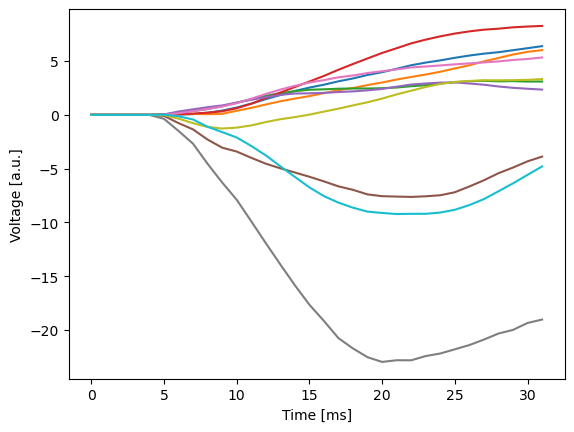

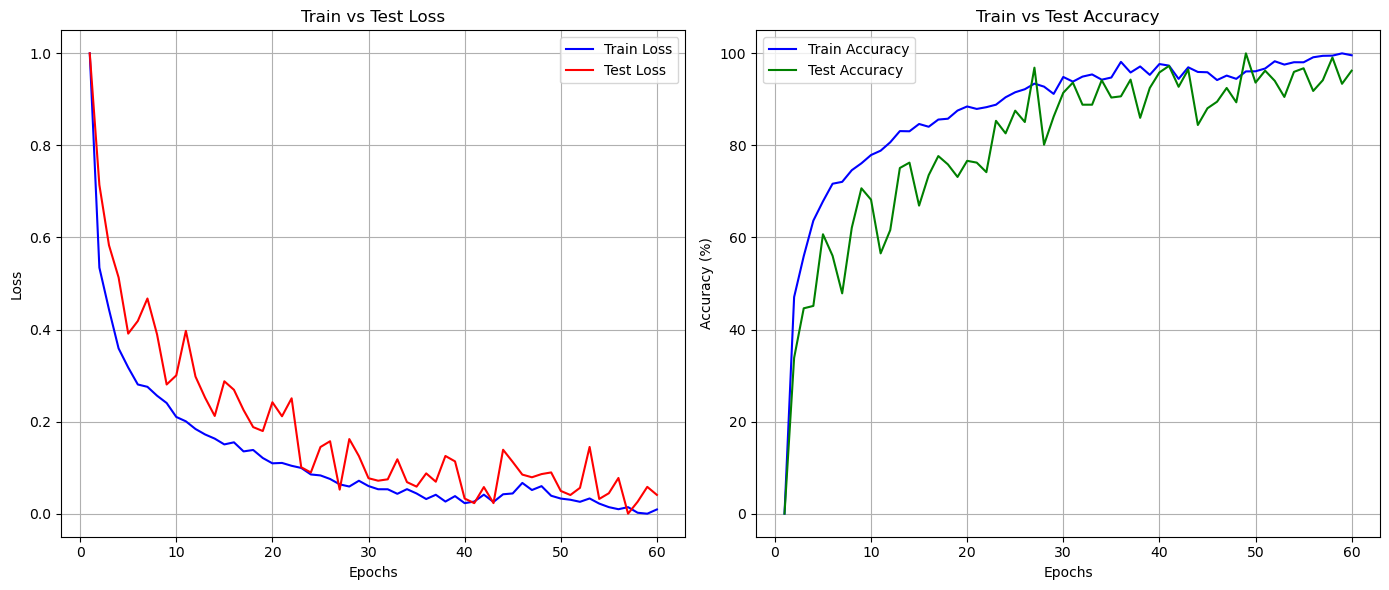

In [29]:
trained_snn = model.snn.cpu()
trained_readout_voltages = trained_snn(example_input.unsqueeze(1))
plt.plot(trained_readout_voltages.squeeze(1).detach().numpy())

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()


# Funktion zum Normalisieren der Loss-Werte auf den Bereich [0, 1]
def normalize_loss(losses):
    max_loss = np.max(losses)
    min_loss = np.min(losses)
    return (losses - min_loss) / (max_loss - min_loss)

# Beispiel für die Normalisierung der Loss-Werte
normalized_train_losses = normalize_loss(train_losses)
normalized_test_losses = normalize_loss(test_losses)

# Normalisierung der Accuracy-Werte auf den Bereich [0, 100]
def normalize_accuracy(accuracies):
    max_accuracy = np.max(accuracies)
    min_accuracy = np.min(accuracies)
    return (accuracies - min_accuracy) * 100 / (max_accuracy - min_accuracy)

# Falls du die Accuracies normalisieren möchtest
normalized_train_accuracies = normalize_accuracy(np.array(train_accuracies))
normalized_test_accuracies = normalize_accuracy(np.array(test_accuracies))

epochs = np.arange(1, EPOCHS + 1)

# Plotten der Verlust- und Genauigkeitsdiagramme
plt.figure(figsize=(14, 6))

# Subplot für den Verlust
plt.subplot(1, 2, 1)
plt.plot(epochs, normalized_train_losses[:EPOCHS], label="Train Loss", color="blue")
plt.plot(epochs, normalized_test_losses[:EPOCHS], label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)

# Subplot für die Genauigkeit
plt.subplot(1, 2, 2)
plt.plot(epochs, normalized_train_accuracies[:EPOCHS], label="Train Accuracy", color="blue")
plt.plot(epochs, normalized_test_accuracies[:EPOCHS], label="Test Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [33]:
from norse.torch.module.leaky_integrator import LILinearCell
from norse.torch.functional.lif import LIFFeedForwardState
from norse.torch.functional.leaky_integrator import LIState
import torch.nn as nn

from typing import NamedTuple


class ConvNet(torch.nn.Module):
    def __init__(self, num_channels=1, feature_size=28, method="super", alpha=100):
        super(ConvNet, self).__init__()

        self.features = int(((feature_size - 4) / 2 - 4) / 2)

        self.conv1 = torch.nn.Conv2d(num_channels, 20, 5, 1)
        self.conv2 = torch.nn.Conv2d(20, 50, 5, 1)
        self.fc1 = torch.nn.Linear(self.features * self.features * 50, 500)
        self.lif0 = LIFCell(p=LIFParameters(method=method, alpha=alpha))
        self.lif1 = LIFCell(p=LIFParameters(method=method, alpha=alpha))
        self.lif2 = LIFCell(p=LIFParameters(method=method, alpha=alpha))
        self.out = LILinearCell(500, 10)

    def forward(self, x):
        seq_length = x.shape[0]
        batch_size = x.shape[1]

        # specify the initial states
        s0 = s1 = s2 = so = None

        voltages = torch.zeros(
            seq_length, batch_size, 10, device=x.device, dtype=x.dtype
        )

        for ts in range(seq_length):
            z = self.conv1(x[ts, :])
            z, s0 = self.lif0(z, s0)
            z = torch.nn.functional.max_pool2d(z, 2, 2)
            z = 10 * self.conv2(z)
            z, s1 = self.lif1(z, s1)
            z = torch.nn.functional.max_pool2d(z, 2, 2)
            z = z.view(-1, 4**2 * 50)
            z = self.fc1(z)
            z, s2 = self.lif2(z, s2)
            v, so = self.out(torch.nn.functional.relu(z), so)
            voltages[ts, :, :] = v
        return voltages

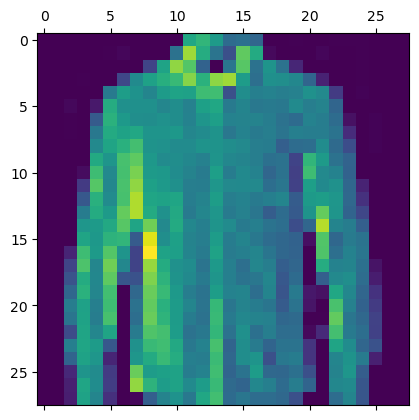

6


In [34]:
img, label = train_data[4]

plt.matshow(img[0])
plt.show()
print(label)

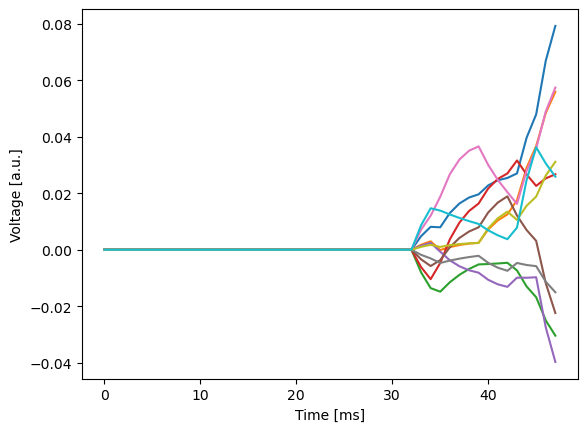

In [35]:
T = 48
example_encoder = ConstantCurrentLIFEncoder(T)
example_input = example_encoder(img)
example_snn = ConvNet()
example_readout_voltages = example_snn(example_input.unsqueeze(1))

plt.plot(example_readout_voltages.squeeze(1).detach().numpy())
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()

In [36]:
T = 48
LR = 0.001
EPOCHS = 60  # Increase this for improved accuracy
BATCH_SIZE = 32

DEVICE = torch.device("cpu")
model = Model(
    encoder=ConstantCurrentLIFEncoder(T), snn=ConvNet(alpha=80), decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): ConstantCurrentLIFEncoder()
  (snn): ConvNet(
    (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=800, out_features=500, bias=True)
    (lif0): LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(80)), dt=0.001)
    (lif1): LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(80)), dt=0.001)
    (lif2): LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(80)), dt=0.001)
    (out): LILinearCell()
  )
)

In [37]:
from tqdm.notebook import tqdm, trange
# Training und Testen über mehrere Epochen
train_losses = []  # Liste für durchschnittliche Trainingsverluste pro Epoche
test_losses = []   # Liste für durchschnittliche Testverluste pro Epoche
test_accuracies = []  # Liste für Testgenauigkeiten pro Epoche
train_accuracies = []  # Liste für Trainingsgenauigkeiten pro Epoche

for epoch in trange(EPOCHS, desc="Training"):
    # Training
    train_loss, mean_train_loss, train_accuracy = train(model, DEVICE, train_loader, optimizer, epoch, EPOCHS)
    train_losses.append(mean_train_loss)  # Füge den mittleren Trainingsverlust pro Epoche hinzu
    train_accuracies.append(train_accuracy)  # Füge die Trainingsgenauigkeit pro Epoche hinzu
    
    # Testen
    test_loss, test_accuracy = test(model, DEVICE, test_loader, epoch)
    test_losses.append(test_loss)  # Füge den Testverlust pro Epoche hinzu
    test_accuracies.append(test_accuracy)  # Füge die Testgenauigkeit pro Epoche hinzu
    
    # Ausgabe für jedes Epoch
    print(
        f"Epoch {epoch+1}/{EPOCHS}, "
        f"Train Loss: {mean_train_loss:.2f}, "
        f"Train Accuracy: {train_accuracy:.2f}%, "
        f"Test Loss: {test_loss:.2f}, "
        f"Test Accuracy: {test_accuracy:.2f}%"
    )


Training:   0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/60, Train Loss: 1.15, Train Accuracy: 60.25%, Test Loss: 0.77, Test Accuracy: 71.14%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/60, Train Loss: 0.68, Train Accuracy: 74.79%, Test Loss: 0.66, Test Accuracy: 75.67%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/60, Train Loss: 0.60, Train Accuracy: 78.02%, Test Loss: 0.60, Test Accuracy: 78.08%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/60, Train Loss: 0.55, Train Accuracy: 79.75%, Test Loss: 0.57, Test Accuracy: 79.02%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/60, Train Loss: 0.52, Train Accuracy: 80.97%, Test Loss: 0.53, Test Accuracy: 80.30%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/60, Train Loss: 0.49, Train Accuracy: 82.03%, Test Loss: 0.52, Test Accuracy: 81.14%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/60, Train Loss: 0.47, Train Accuracy: 82.59%, Test Loss: 0.53, Test Accuracy: 80.37%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/60, Train Loss: 0.45, Train Accuracy: 83.23%, Test Loss: 0.50, Test Accuracy: 81.42%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/60, Train Loss: 0.43, Train Accuracy: 83.90%, Test Loss: 0.48, Test Accuracy: 81.76%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/60, Train Loss: 0.42, Train Accuracy: 84.53%, Test Loss: 0.48, Test Accuracy: 82.71%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11/60, Train Loss: 0.40, Train Accuracy: 85.05%, Test Loss: 0.47, Test Accuracy: 82.87%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12/60, Train Loss: 0.39, Train Accuracy: 85.75%, Test Loss: 0.46, Test Accuracy: 82.88%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13/60, Train Loss: 0.37, Train Accuracy: 86.10%, Test Loss: 0.46, Test Accuracy: 83.42%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14/60, Train Loss: 0.37, Train Accuracy: 86.46%, Test Loss: 0.44, Test Accuracy: 84.08%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15/60, Train Loss: 0.35, Train Accuracy: 86.94%, Test Loss: 0.44, Test Accuracy: 83.85%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16/60, Train Loss: 0.34, Train Accuracy: 87.26%, Test Loss: 0.44, Test Accuracy: 84.16%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17/60, Train Loss: 0.33, Train Accuracy: 87.70%, Test Loss: 0.44, Test Accuracy: 84.10%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18/60, Train Loss: 0.32, Train Accuracy: 87.91%, Test Loss: 0.43, Test Accuracy: 84.72%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19/60, Train Loss: 0.31, Train Accuracy: 88.52%, Test Loss: 0.43, Test Accuracy: 84.46%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20/60, Train Loss: 0.30, Train Accuracy: 88.84%, Test Loss: 0.44, Test Accuracy: 84.45%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21/60, Train Loss: 0.29, Train Accuracy: 89.13%, Test Loss: 0.43, Test Accuracy: 84.83%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22/60, Train Loss: 0.28, Train Accuracy: 89.31%, Test Loss: 0.43, Test Accuracy: 84.62%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23/60, Train Loss: 0.27, Train Accuracy: 89.80%, Test Loss: 0.44, Test Accuracy: 84.37%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24/60, Train Loss: 0.27, Train Accuracy: 90.06%, Test Loss: 0.44, Test Accuracy: 84.51%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25/60, Train Loss: 0.26, Train Accuracy: 90.32%, Test Loss: 0.44, Test Accuracy: 84.59%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26/60, Train Loss: 0.25, Train Accuracy: 90.80%, Test Loss: 0.44, Test Accuracy: 84.68%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27/60, Train Loss: 0.24, Train Accuracy: 91.07%, Test Loss: 0.45, Test Accuracy: 84.72%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28/60, Train Loss: 0.24, Train Accuracy: 91.22%, Test Loss: 0.45, Test Accuracy: 84.50%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29/60, Train Loss: 0.23, Train Accuracy: 91.45%, Test Loss: 0.46, Test Accuracy: 84.81%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30/60, Train Loss: 0.22, Train Accuracy: 91.87%, Test Loss: 0.46, Test Accuracy: 84.51%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31/60, Train Loss: 0.22, Train Accuracy: 92.08%, Test Loss: 0.47, Test Accuracy: 84.54%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32/60, Train Loss: 0.21, Train Accuracy: 92.19%, Test Loss: 0.47, Test Accuracy: 84.56%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33/60, Train Loss: 0.20, Train Accuracy: 92.52%, Test Loss: 0.47, Test Accuracy: 84.55%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34/60, Train Loss: 0.20, Train Accuracy: 92.62%, Test Loss: 0.47, Test Accuracy: 84.56%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35/60, Train Loss: 0.19, Train Accuracy: 92.90%, Test Loss: 0.49, Test Accuracy: 84.40%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36/60, Train Loss: 0.18, Train Accuracy: 93.16%, Test Loss: 0.48, Test Accuracy: 84.53%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37/60, Train Loss: 0.18, Train Accuracy: 93.44%, Test Loss: 0.49, Test Accuracy: 84.41%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38/60, Train Loss: 0.17, Train Accuracy: 93.64%, Test Loss: 0.50, Test Accuracy: 84.68%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39/60, Train Loss: 0.16, Train Accuracy: 93.98%, Test Loss: 0.51, Test Accuracy: 84.29%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40/60, Train Loss: 0.16, Train Accuracy: 94.17%, Test Loss: 0.51, Test Accuracy: 84.32%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41/60, Train Loss: 0.16, Train Accuracy: 94.09%, Test Loss: 0.52, Test Accuracy: 84.56%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42/60, Train Loss: 0.15, Train Accuracy: 94.42%, Test Loss: 0.53, Test Accuracy: 84.30%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43/60, Train Loss: 0.15, Train Accuracy: 94.60%, Test Loss: 0.53, Test Accuracy: 84.42%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44/60, Train Loss: 0.14, Train Accuracy: 94.82%, Test Loss: 0.55, Test Accuracy: 84.25%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45/60, Train Loss: 0.14, Train Accuracy: 94.89%, Test Loss: 0.53, Test Accuracy: 84.45%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46/60, Train Loss: 0.14, Train Accuracy: 94.94%, Test Loss: 0.55, Test Accuracy: 84.47%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47/60, Train Loss: 0.13, Train Accuracy: 95.00%, Test Loss: 0.55, Test Accuracy: 84.61%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48/60, Train Loss: 0.13, Train Accuracy: 95.26%, Test Loss: 0.57, Test Accuracy: 83.95%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49/60, Train Loss: 0.12, Train Accuracy: 95.51%, Test Loss: 0.57, Test Accuracy: 84.26%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 50/60, Train Loss: 0.12, Train Accuracy: 95.58%, Test Loss: 0.57, Test Accuracy: 84.27%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 51/60, Train Loss: 0.12, Train Accuracy: 95.90%, Test Loss: 0.59, Test Accuracy: 84.16%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 52/60, Train Loss: 0.11, Train Accuracy: 95.87%, Test Loss: 0.60, Test Accuracy: 84.44%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 53/60, Train Loss: 0.11, Train Accuracy: 96.15%, Test Loss: 0.60, Test Accuracy: 83.91%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 54/60, Train Loss: 0.11, Train Accuracy: 96.06%, Test Loss: 0.60, Test Accuracy: 84.19%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 55/60, Train Loss: 0.10, Train Accuracy: 96.28%, Test Loss: 0.61, Test Accuracy: 84.25%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 56/60, Train Loss: 0.10, Train Accuracy: 96.42%, Test Loss: 0.62, Test Accuracy: 84.06%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 57/60, Train Loss: 0.10, Train Accuracy: 96.45%, Test Loss: 0.62, Test Accuracy: 84.19%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 58/60, Train Loss: 0.10, Train Accuracy: 96.47%, Test Loss: 0.64, Test Accuracy: 83.99%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 59/60, Train Loss: 0.09, Train Accuracy: 96.56%, Test Loss: 0.64, Test Accuracy: 84.07%


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 60/60, Train Loss: 0.09, Train Accuracy: 96.51%, Test Loss: 0.63, Test Accuracy: 84.21%


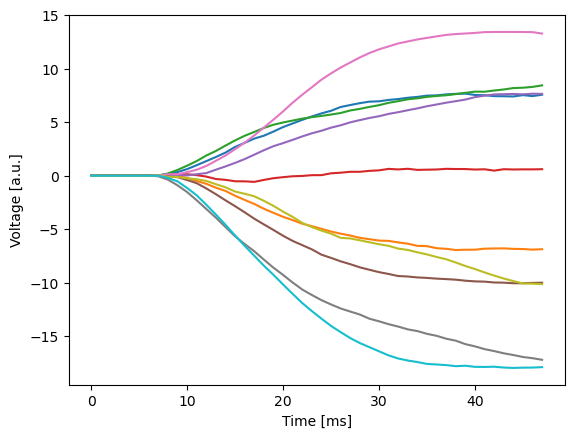

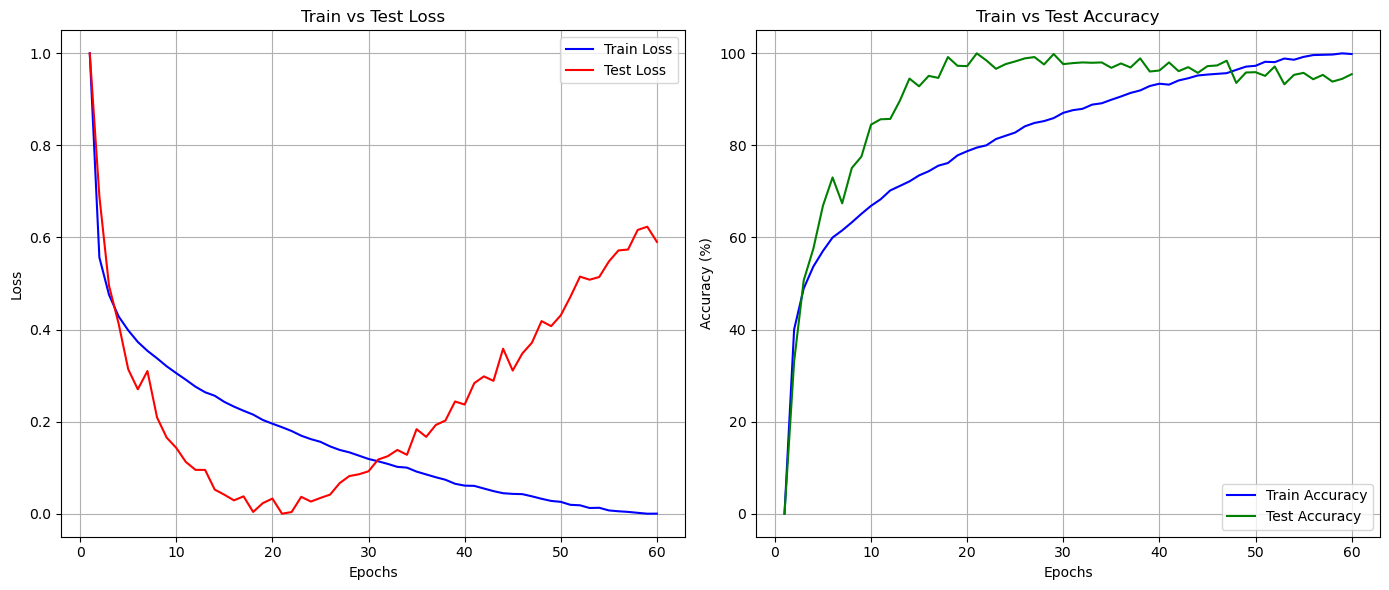

In [39]:
trained_snn = model.snn.cpu()
trained_readout_voltages = trained_snn(example_input.unsqueeze(1))
plt.plot(trained_readout_voltages.squeeze(1).detach().numpy())

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()


# Funktion zum Normalisieren der Loss-Werte auf den Bereich [0, 1]
def normalize_loss(losses):
    max_loss = np.max(losses)
    min_loss = np.min(losses)
    return (losses - min_loss) / (max_loss - min_loss)

# Beispiel für die Normalisierung der Loss-Werte
normalized_train_losses = normalize_loss(train_losses)
normalized_test_losses = normalize_loss(test_losses)

# Normalisierung der Accuracy-Werte auf den Bereich [0, 100]
def normalize_accuracy(accuracies):
    max_accuracy = np.max(accuracies)
    min_accuracy = np.min(accuracies)
    return (accuracies - min_accuracy) * 100 / (max_accuracy - min_accuracy)

# Falls du die Accuracies normalisieren möchtest
normalized_train_accuracies = normalize_accuracy(np.array(train_accuracies))
normalized_test_accuracies = normalize_accuracy(np.array(test_accuracies))

epochs = np.arange(1, EPOCHS + 1)

# Plotten der Verlust- und Genauigkeitsdiagramme
plt.figure(figsize=(14, 6))

# Subplot für den Verlust
plt.subplot(1, 2, 1)
plt.plot(epochs, normalized_train_losses[:EPOCHS], label="Train Loss", color="blue")
plt.plot(epochs, normalized_test_losses[:EPOCHS], label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)

# Subplot für die Genauigkeit
plt.subplot(1, 2, 2)
plt.plot(epochs, normalized_train_accuracies[:EPOCHS], label="Train Accuracy", color="blue")
plt.plot(epochs, normalized_test_accuracies[:EPOCHS], label="Test Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

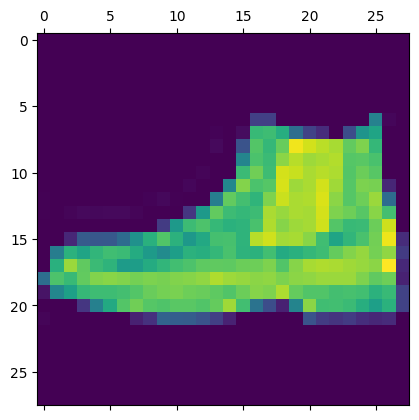

In [69]:
plt.matshow(np.squeeze(img, 0))